---
title: ""
author: ""
date: ""
format:
  pdf:
    pdf-engine: xelatex         # use XeLaTeX to avoid encoding issues and support better fonts
    keep-tex: false             # do not keep intermediate .tex file
toc: false                      # generate Table of Contents
lof: false                      # generate List of Figures
lot: false                      # generate List of Tables
number-sections: true           # add numbering to section headers
lang: en                        # set document language to English
encoding: UTF-8                 # ensure UTF-8 encoding
code-overflow: wrap             # wrap long lines of code to avoid overflow in PDF
df-print: kable                 # render data frames as kable tables instead of console text
execute:
  echo: True                    # Show code in output
  warning: false                # suppress warnings in output
  message: false                # suppress messages (e.g., from library loading)
  code-fold: false              # do not fold code chunks
---

\clearpage
# Group Coursework 1 {.unnumbered .unlisted}

**Course:** BUSI70623 Applied Econometrics  

**Assignment:** Group Coursework 1  

**Group:** Group 6  


---




**Group Members:**

- Niamh O’Hara  
- Katarina Reiten  
- Zakaria Achakane  
- Kiril Grozdev  
- Saanya Xavier  

\clearpage

\tableofcontents
\listoffigures
\listoftables
\clearpage

# 1.0 Introduction
Comment

## 1.1 Data Preparation

In [89]:

# Load libraries
library(lmtest)
library(writexl)
library(sandwich)
library(ggplot2)
library(xts)
library(dplyr)
library(lubridate)
library(knitr)
library(data.table)
library(tidyverse)
library(tidyr)


# Load datasets
rates <- read.csv("Effective Federal Funds Rate (EFFR) (Monthly).csv")
ff3_raw <- read.csv("F-F_Research_Data_Factors.csv", skip = 3)
industry12_raw <- read.csv("12_Industry_Portfolios.csv", skip = 11)
industry49_raw <- read.csv("49_Industry_Portfolios.csv", skip = 11)

# Clean datasets
rates <- rates %>%
  rename(date = observation_date,
         interest_rate = EFFR) %>%
  mutate(date = as.Date(date)) %>%                      #date format
  select(date, interest_rate) %>%                       #select needed columns
  distinct(date, .keep_all = TRUE)

ff3 <- ff3_raw %>%
  rename(raw_date = X) %>%
  filter(raw_date != "Annual") %>%                      #remove annual data 
  mutate(
    date = as.Date(paste0(raw_date, "01"), "%Y%m%d"),   #convert to date
    market_excess_return = as.numeric(Mkt.RF) / 100     #convert to decimal
  ) %>%
  select(date, market_excess_return) %>%                #select needed columns
  distinct(date, .keep_all = TRUE)                      #one row per month 

industry12 <- industry12_raw %>%
  rename(raw_date = X) %>%
  filter(raw_date != "Annual") %>%                      #remove annual data
  mutate(
    date = as.Date(paste0(raw_date, "01"), "%Y%m%d")    #convert to date
  ) %>%
  select(-raw_date) %>%                                 #drop raw date
  mutate(across(-date, as.numeric)) %>%                 #make numeric
  mutate(across(-date, ~ . / 100)) %>%                  #covert to decimal
  distinct(date, .keep_all = TRUE)                      #one row per month

toys <- industry49_raw %>%
  rename(raw_date = X) %>% 
  filter(raw_date != "Annual") %>%                      #remove annual data
  mutate(
    date = as.Date(paste0(raw_date, "01"), "%Y%m%d"),   #convert to date
    Toys = as.numeric(Toys) / 100                       #convert to decimal
  ) %>%
  select(date, Toys) %>%                                #select needed columns
  distinct(date, .keep_all = TRUE)                      #one observation per month

# Merge datasets 
data_merged <- ff3 %>%
  left_join(rates, by = "date") %>%
  left_join(toys, by = "date")
data_merged <- data_merged %>%
  filter(date >= as.Date("2000-01-01"))

# Add the 12 industry portfolios to the merged dataset 
data_merged <- data_merged %>%
  left_join(industry12, by = "date")

# Check
nrow(ff3) == nrow(data_merged)

head(data_merged)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `market_excess_return = as.numeric(Mkt.RF)/100`.
Caused by warning:
! NAs introduced by coercion”


Warning message:
“There were 12 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(-date, as.numeric)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 11 remaining warnings.”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Toys = as.numeric(Toys)/100`.
Caused by warning:
! NAs introduced by coercion”


[1] FALSE

,date,market_excess_return,interest_rate,Toys,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2000-01-01,-0.0474,NA,-0.1372,-0.0472,-0.0133,-0.0876,0.0128,-0.0837,-0.0528,-0.0385,0.0554,-0.1101,0.0763,-0.0449,-0.0513
2,2000-02-01,0.0246,NA,0.0041,-0.0627,-0.0881,-0.0154,-0.0560,-0.1019,0.1794,-0.0369,-0.0707,-0.0395,-0.0251,-0.0880,-0.0170
3,2000-03-01,0.0521,NA,0.0783,0.0743,0.1089,0.1106,0.1192,-0.0388,0.0422,0.0827,0.0589,0.1339,-0.0003,0.1695,0.0521
4,2000-04-01,-0.0639,NA,0.0013,-0.0196,0.0869,0.0180,-0.0231,0.0019,-0.1052,-0.0833,0.0742,-0.0448,0.0504,-0.0369,-0.0033
5,2000-05-01,-0.0439,NA,0.0112,0.0710,-0.1231,-0.0269,0.0939,0.0197,-0.1086,-0.0997,0.0396,-0.0283,0.0372,0.0497,-0.0202
6,2000-06-01,0.0468,NA,-0.0168,0.0218,-0.0899,-0.0020,-0.0505,-0.0514,0.1261,0.0399,-0.0468,-0.0221,0.1099,-0.0428,0.0123


# 2.0 Harmonising, Visualising, and Interpreting Data

Comment 

## 2.1 Time series central bank policy rate (US)

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`).”


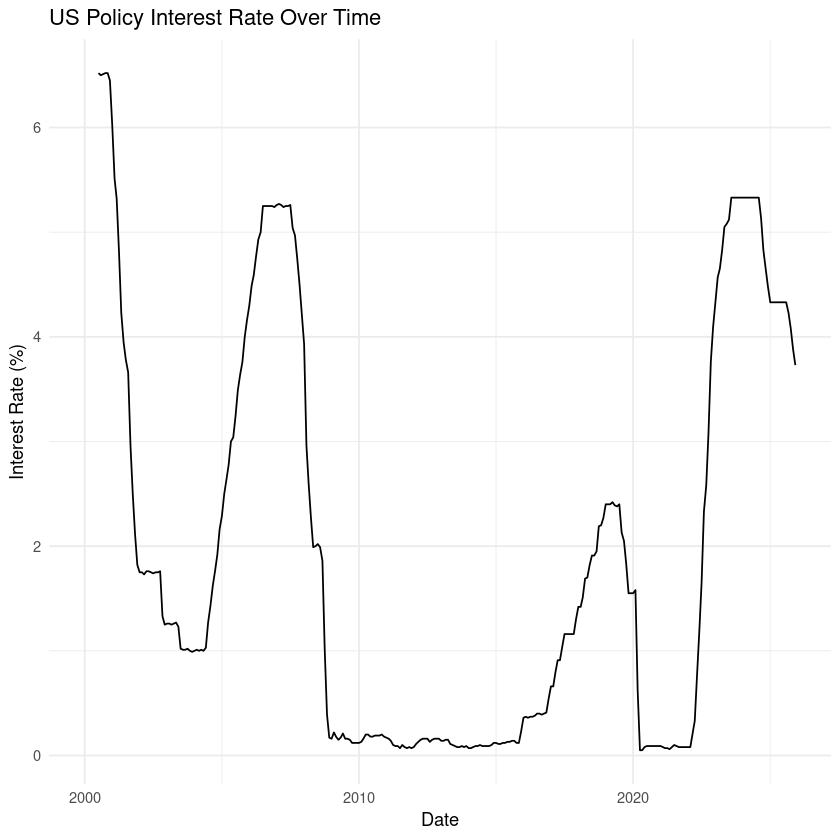

In [90]:
ggplot(data_merged, aes(x = date, y = interest_rate)) +
  geom_line() +
  labs(
    title = "US Policy Interest Rate Over Time",
    x = "Date",
    y = "Interest Rate (%)"
  ) +
  theme_minimal()

  ggsave("interest_rate_timeseries.png", width = 7, height = 4)



## 2.2 Time series excess returns

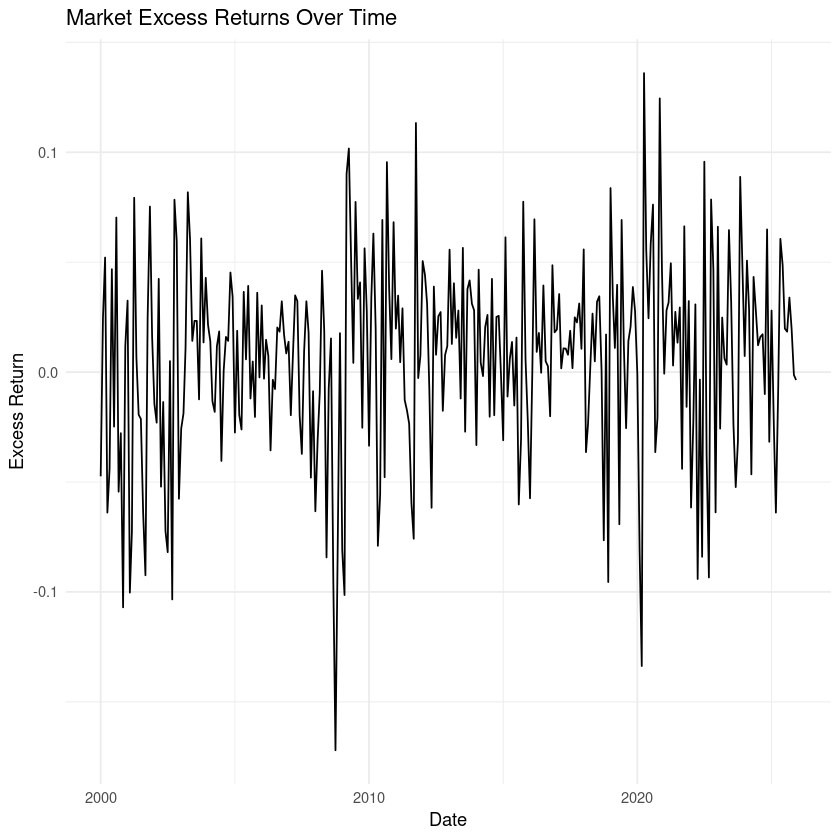

In [91]:
ggplot(data_merged, aes(x = date, y = market_excess_return)) +
  geom_line() +
  labs(
    title = "Market Excess Returns Over Time",
    x = "Date",
    y = "Excess Return"
  ) +
  theme_minimal()

ggsave("market_excess_returns.png", width = 7, height = 4)

## 2.3 Time series returns for each of the 12 industries

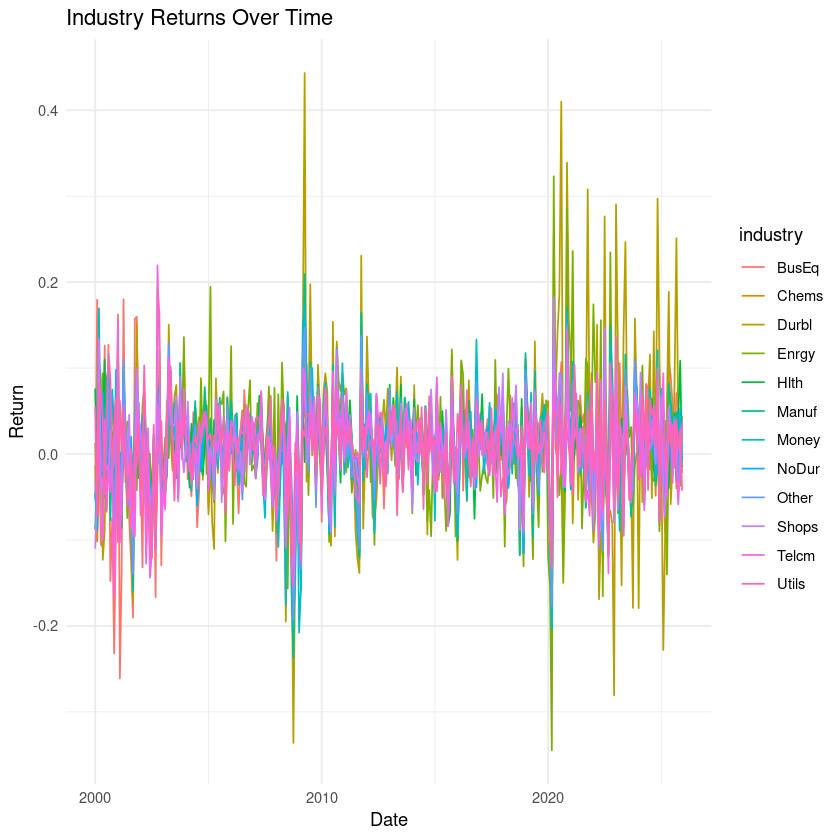

In [92]:
industry12_long <- data_merged %>%
  select(date, NoDur, Durbl, Manuf, Enrgy, Chems, BusEq,
         Telcm, Utils, Shops, Hlth, Money, Other) %>%
  pivot_longer(
    cols = -date,
    names_to = "industry",
    values_to = "return"
  )

ggplot(industry12_long, aes(x = date, y = return, color = industry)) +
  geom_line() +
  labs(
    title = "Industry Returns Over Time",
    x = "Date",
    y = "Return"
  ) +
  theme_minimal()

ggsave("industry_returns_timeseries.png", width = 7, height = 4)

## 2.4 Time series returns Toys

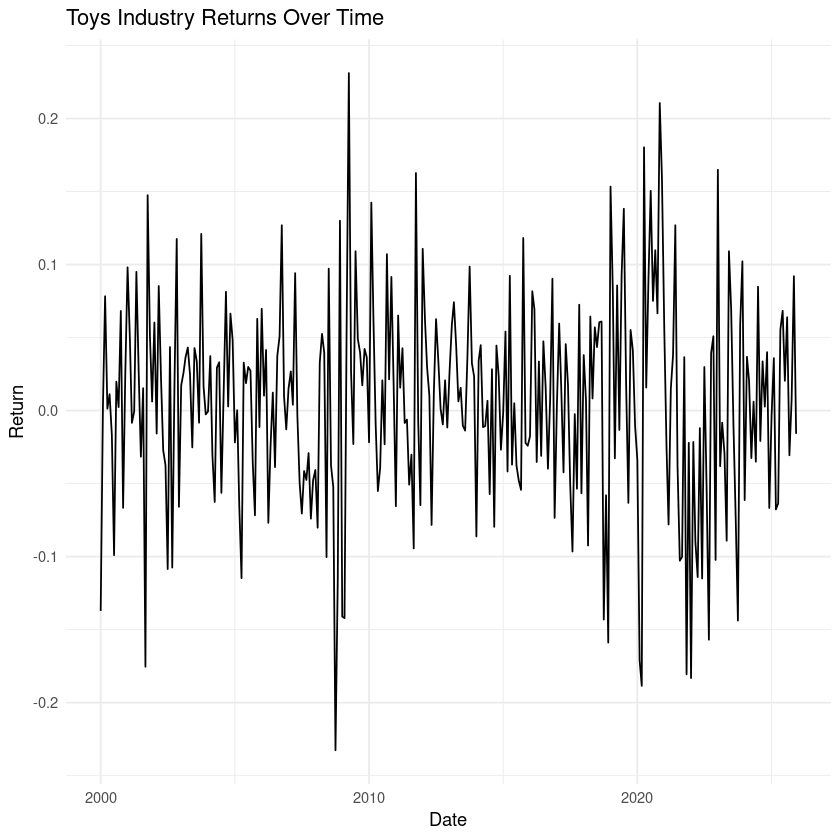

In [93]:
ggplot(data_merged, aes(x = date, y = Toys)) +
  geom_line() +
  labs(
    title = "Toys Industry Returns Over Time",
    x = "Date",
    y = "Return"
  ) +
  theme_minimal()

ggsave("toys_returns_timeseries.png", width = 7, height = 4)


# 3.0 Estimating Regressions

Comment 

In [94]:
# Calculate the monthly change in the policy interest rate 
data_merged <- data_merged %>%
  mutate(
    d_interest_rate = interest_rate - lag(interest_rate)
  )

## 3.1 Market excess return regression

In [95]:
# Estimate regression: regress market excess returns on changes in the interest rate
model_market <- lm(market_excess_return ~ d_interest_rate, data = data_merged)

# Estimate regression
model_market <- lm(market_excess_return ~ d_interest_rate,
                   data = data_merged)

# Display regression summary
summary(model_market)

# Robust standard errors
lmtest::coeftest(model_market,
                 vcov = sandwich::vcovHC(model_market, type = "HC1"))


Call:
lm(formula = market_excess_return ~ d_interest_rate, data = data_merged)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.153411 -0.025526  0.005376  0.025574  0.146754 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)     0.006726   0.002583   2.604  0.00967 **
d_interest_rate 0.030136   0.014105   2.137  0.03343 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04505 on 303 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.01484,	Adjusted R-squared:  0.01159 
F-statistic: 4.565 on 1 and 303 DF,  p-value: 0.03343



t test of coefficients:

                 Estimate Std. Error t value Pr(>|t|)   
(Intercept)     0.0067255  0.0025419  2.6458 0.008575 **
d_interest_rate 0.0301362  0.0234743  1.2838 0.200195   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## 3.2 12 industries regression

In [96]:
# Names of the 12 industry portfolios
industry_names <- c("NoDur", "Durbl", "Manuf", "Enrgy", "Chems",
                    "BusEq", "Telcm", "Utils", "Shops",
                    "Hlth", "Money", "Other")


# Run regressions industry by industry
for (i in industry_names) {

  cat("\nIndustry:", i, "\n")

  model_industry <- lm(as.formula(paste(i, "~ d_interest_rate")),
                       data = data_merged)

  # Print regression output
  print(summary(model_industry))

  # Print robust standard errors
  print(lmtest::coeftest(model_industry,
                         vcov = sandwich::vcovHC(model_industry, type = "HC1")))
}



Industry: NoDur 

Call:
lm(formula = as.formula(paste(i, "~ d_interest_rate")), data = data_merged)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.122958 -0.019456  0.001684  0.023844  0.092344 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.007856   0.002035   3.861 0.000138 ***
d_interest_rate 0.028600   0.011111   2.574 0.010529 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03549 on 303 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.0214,	Adjusted R-squared:  0.01817 
F-statistic: 6.625 on 1 and 303 DF,  p-value: 0.01053


t test of coefficients:

                 Estimate Std. Error t value  Pr(>|t|)    
(Intercept)     0.0078564  0.0020226  3.8843 0.0001261 ***
d_interest_rate 0.0285995  0.0165116  1.7321 0.0842747 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Industry: Durbl 

Call:
lm(formula = as.

## 3.3 Toys sub-industry regression

In [97]:
# Regress Toys industry returns on changes in the interest rate
model_toys <- lm(Toys ~ d_interest_rate,
                 data = data_merged)

# View standard regression output
summary(model_toys)

# Robust standard errors for the Toys regression
lmtest::coeftest(model_toys,
                 vcov = sandwich::vcovHC(model_toys, type = "HC1"))


Call:
lm(formula = Toys ~ d_interest_rate, data = data_merged)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.230358 -0.043494  0.004875  0.039201  0.225106 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.006299   0.004058   1.552    0.122
d_interest_rate 0.010167   0.022161   0.459    0.647

Residual standard error: 0.07078 on 303 degrees of freedom
  (7 observations deleted due to missingness)
Multiple R-squared:  0.0006942,	Adjusted R-squared:  -0.002604 
F-statistic: 0.2105 on 1 and 303 DF,  p-value: 0.6467



t test of coefficients:

                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.0062986  0.0039942  1.5769   0.1159
d_interest_rate 0.0101671  0.0361644  0.2811   0.7788


# 4.0 Causality

Comment 

# 5.0 Control variables

Comment 

# 6.0 Causality Revisited

Comment 